In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100


In [2]:
# Load and prepare data
print("Loading CDF data...")
csv_files = glob.glob('cdf_data/*.csv')
df_cdf = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

print("Loading CME data...")
csv_files = glob.glob('cme_data/*.csv')
df_cme = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

# Convert to datetime
df_cdf['datetime'] = pd.to_datetime(df_cdf['epoch_for_cdf_mod'])
df_cme['datetime'] = pd.to_datetime(df_cme['t0'])

# Sort data by datetime
df_cdf = df_cdf.sort_values('datetime').reset_index(drop=True)
df_cme = df_cme.sort_values('datetime').reset_index(drop=True)


Loading CDF data...
Loading CME data...


In [3]:
from matplotlib.lines import Line2D

def create_clean_cme_plot(df_cdf, df_cme, 
                         time_window_months=3,
                         min_cme_velocity=800,
                         data_downsample_factor=50,
                         max_cme_events=20,
                         figsize=(16, 10)):
    """
    Create a clean, focused CME plot with minimal clutter
    
    Parameters:
    - time_window_months: Number of months to show at once
    - min_cme_velocity: Minimum CME velocity to show (km/s)
    - data_downsample_factor: Show every Nth data point
    - max_cme_events: Maximum number of CME events to show
    - figsize: Figure size
    """
    
    # Filter for significant CME events only
    significant_cmes = df_cme[df_cme['v'] >= min_cme_velocity].copy()
    
    # Sort by velocity and take only the most significant events
    significant_cmes = significant_cmes.nlargest(max_cme_events, 'v')
    
    # Find an active time period with multiple significant CMEs
    if len(significant_cmes) > 0:
        # Find the period with the most activity
        significant_cmes['date'] = significant_cmes['datetime'].dt.date
        daily_counts = significant_cmes.groupby('date').size()
        most_active_date = daily_counts.idxmax()
        
        # Center the time window around this active period
        center_date = pd.Timestamp(most_active_date)
        start_date = center_date - timedelta(days=time_window_months*30//2)
        end_date = center_date + timedelta(days=time_window_months*30//2)
    else:
        # If no significant CMEs, use middle of dataset
        mid_time = df_cdf['datetime'].min() + (df_cdf['datetime'].max() - df_cdf['datetime'].min()) / 2
        start_date = mid_time - timedelta(days=time_window_months*30//2)
        end_date = mid_time + timedelta(days=time_window_months*30//2)
    
    # Filter CDF data for time window
    cdf_filtered = df_cdf[(df_cdf['datetime'] >= start_date) & 
                         (df_cdf['datetime'] <= end_date)].copy()
    
    # Downsample CDF data for cleaner plotting
    if len(cdf_filtered) > data_downsample_factor:
        step = len(cdf_filtered) // data_downsample_factor
        cdf_filtered = cdf_filtered.iloc[::step].copy()
    
    # Filter CME data for time window
    cme_filtered = significant_cmes[(significant_cmes['datetime'] >= start_date) & 
                                   (significant_cmes['datetime'] <= end_date)].copy()
    
    print(f"Plotting {len(cdf_filtered)} data points and {len(cme_filtered)} CME events")
    print(f"Time range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    
    # Create subplots
    fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True)
    
    # Plot configurations
    plot_configs = [
        {'col': 'proton_bulk_speed', 'title': 'Solar Wind Speed', 
         'ylabel': 'Speed (km/s)', 'color': 'blue', 'threshold': 500},
        {'col': 'proton_density', 'title': 'Proton Density', 
         'ylabel': 'Density (particles/cm³)', 'color': 'green', 'threshold': 10},
        {'col': 'proton_thermal', 'title': 'Proton Temperature', 
         'ylabel': 'Thermal Speed (km/s)', 'color': 'red', 'threshold': 50},
        {'col': 'alpha_density', 'title': 'Alpha Particle Density', 
         'ylabel': 'Alpha Density (particles/cm³)', 'color': 'purple', 'threshold': 0.3}
    ]
    
    # Plot each parameter
    for i, config in enumerate(plot_configs):
        ax = axes[i]
        
        # Get clean data (remove NaN values)
        mask = cdf_filtered[config['col']].notna()
        clean_data = cdf_filtered[mask]
        
        if len(clean_data) > 0:
            # Plot main data with thicker line
            ax.plot(clean_data['datetime'], clean_data[config['col']], 
                   color=config['color'], linewidth=1.5, alpha=0.8)
            
            # Add threshold line
            ax.axhline(y=config['threshold'], color=config['color'], 
                      linestyle=':', alpha=0.5, linewidth=1)
            
            # Add only the most significant CME events
            for _, cme in cme_filtered.iterrows():
                cme_time = cme['datetime']
                cme_velocity = cme['v']
                
                # Color based on velocity
                if cme_velocity >= 1500:
                    color = 'darkred'
                    linewidth = 3
                    alpha = 0.9
                elif cme_velocity >= 1000:
                    color = 'red'
                    linewidth = 2.5
                    alpha = 0.8
                else:
                    color = 'orange'
                    linewidth = 2
                    alpha = 0.7
                
                # Add CME line
                ax.axvline(x=cme_time, color=color, linestyle='--', 
                          linewidth=linewidth, alpha=alpha)
                
                # Add velocity annotation for very fast CMEs
                if cme_velocity >= 1200:
                    ax.annotate(f'{cme_velocity:.0f}', 
                              xy=(cme_time, ax.get_ylim()[1]*0.9),
                              xytext=(5, 0), textcoords='offset points',
                              fontsize=8, color=color, weight='bold',
                              rotation=90, ha='left', va='top')
        
        # Formatting
        ax.set_title(f"{config['title']} ({len(clean_data)} points)", 
                    fontsize=12, pad=10)
        ax.set_ylabel(config['ylabel'], fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', labelsize=9)
        
        # Set reasonable y-limits to avoid extreme outliers
        if len(clean_data) > 0:
            y_data = clean_data[config['col']]
            q1, q99 = np.percentile(y_data.dropna(), [1, 99])
            ax.set_ylim(q1*0.9, q99*1.1)
    
    # Format x-axis
    axes[-1].set_xlabel('Date', fontsize=10)
    axes[-1].xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    axes[-1].xaxis.set_major_locator(mdates.DayLocator(interval=max(1, time_window_months*30//10)))
    plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45)
    legend_elements = [
        Line2D([0], [0], color='darkred', linestyle='--', linewidth=3, 
                  label='Extreme CME (>1500 km/s)'),
        Line2D([0], [0], color='red', linestyle='--', linewidth=2.5, 
                  label='Fast CME (1000-1500 km/s)'),
        Line2D([0], [0], color='orange', linestyle='--', linewidth=2, 
                  label='Moderate CME (800-1000 km/s)')
    ]
    axes[0].legend(handles=legend_elements, loc='upper right', fontsize=9)
    
    plt.suptitle(f'Solar Wind Parameters vs Major CME Events\n'
                f'{start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}',
                fontsize=14, y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    # Print event summary
    print(f"\n=== Event Summary ===")
    print(f"Showing {len(cme_filtered)} major CME events (v >= {min_cme_velocity} km/s)")
    if len(cme_filtered) > 0:
        print(f"Velocity range: {cme_filtered['v'].min():.0f} - {cme_filtered['v'].max():.0f} km/s")
        print(f"Average velocity: {cme_filtered['v'].mean():.0f} km/s")
        
        print("\nIndividual events:")
        for _, cme in cme_filtered.iterrows():
            print(f"  {cme['datetime'].strftime('%Y-%m-%d %H:%M')} - {cme['v']:.0f} km/s")
    
    return fig, axes

In [4]:
def create_monthly_overview(df_cdf, df_cme, figsize=(16, 8)):
    """
    Create a monthly overview of CME activity and solar wind parameters
    """
    # Resample data to daily averages
    df_cdf_daily = df_cdf.set_index('datetime').resample('D').agg({
        'proton_bulk_speed': 'mean',
        'proton_density': 'mean',
        'proton_thermal': 'mean'
    }).reset_index()
    
    # Count CMEs per day
    df_cme_daily = df_cme.groupby(df_cme['datetime'].dt.date).agg({
        'v': ['count', 'mean', 'max']
    }).reset_index()
    df_cme_daily.columns = ['date', 'cme_count', 'cme_avg_velocity', 'cme_max_velocity']
    df_cme_daily['date'] = pd.to_datetime(df_cme_daily['date'])
    
    # Create plots
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    # Top plot: Solar wind speed with CME activity
    ax1 = axes[0]
    ax1.plot(df_cdf_daily['datetime'], df_cdf_daily['proton_bulk_speed'], 
             color='blue', linewidth=1, alpha=0.7, label='Solar Wind Speed')
    
    # Add CME events as scatter points sized by velocity
    ax1_twin = ax1.twinx()
    scatter = ax1_twin.scatter(df_cme_daily['date'], df_cme_daily['cme_count'], 
                             s=df_cme_daily['cme_max_velocity']/20,
                             c=df_cme_daily['cme_max_velocity'], 
                             cmap='Reds', alpha=0.7, label='CME Events')
    
    ax1.set_ylabel('Solar Wind Speed (km/s)', color='blue')
    ax1_twin.set_ylabel('CME Count per Day', color='red')
    ax1.set_title('Solar Wind Speed and CME Activity Overview')
    ax1.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax1_twin)
    cbar.set_label('Max CME Velocity (km/s)')
    
    # Bottom plot: Proton density and temperature
    ax2 = axes[1]
    ax2.plot(df_cdf_daily['datetime'], df_cdf_daily['proton_density'], 
             color='green', linewidth=1, alpha=0.7, label='Proton Density')
    
    ax2_twin = ax2.twinx()
    ax2_twin.plot(df_cdf_daily['datetime'], df_cdf_daily['proton_thermal'], 
                  color='red', linewidth=1, alpha=0.7, label='Proton Temperature')
    
    ax2.set_ylabel('Proton Density (particles/cm³)', color='green')
    ax2_twin.set_ylabel('Proton Thermal Speed (km/s)', color='red')
    ax2.set_xlabel('Date')
    ax2.grid(True, alpha=0.3)
    
    # Format dates
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()
    
    return fig, axes

In [5]:
def create_cme_impact_analysis(df_cdf, df_cme, impact_window_hours=24, min_velocity=800):
    """
    Analyze the impact of CME events on solar wind parameters
    """
    significant_cmes = df_cme[df_cme['v'] >= min_velocity].copy()
    
    impact_data = []
    
    for _, cme in significant_cmes.iterrows():
        cme_time = cme['datetime']
        
        # Get data before and after CME
        before_start = cme_time - timedelta(hours=impact_window_hours)
        after_end = cme_time + timedelta(hours=impact_window_hours)
        
        before_data = df_cdf[(df_cdf['datetime'] >= before_start) & 
                           (df_cdf['datetime'] < cme_time)]
        after_data = df_cdf[(df_cdf['datetime'] >= cme_time) & 
                          (df_cdf['datetime'] <= after_end)]
        
        if len(before_data) > 5 and len(after_data) > 5:
            # Calculate changes
            params = ['proton_bulk_speed', 'proton_density', 'proton_thermal']
            changes = {}
            
            for param in params:
                before_mean = before_data[param].mean()
                after_mean = after_data[param].mean()
                
                if not pd.isna(before_mean) and not pd.isna(after_mean) and before_mean > 0:
                    change_percent = ((after_mean - before_mean) / before_mean) * 100
                    changes[f'{param}_change'] = change_percent
            
            if changes:
                impact_data.append({
                    'cme_time': cme_time,
                    'cme_velocity': cme['v'],
                    **changes
                })
    
    if impact_data:
        impact_df = pd.DataFrame(impact_data)
        
        # Create correlation plot
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot speed change vs CME velocity
        ax.scatter(impact_df['cme_velocity'], impact_df['proton_bulk_speed_change'], 
                  alpha=0.7, s=60, color='blue', label='Speed Change')
        
        # Add trend line
        if len(impact_df) > 3:
            z = np.polyfit(impact_df['cme_velocity'], impact_df['proton_bulk_speed_change'], 1)
            p = np.poly1d(z)
            ax.plot(impact_df['cme_velocity'], p(impact_df['cme_velocity']), 
                   "r--", alpha=0.8, label='Trend')
        
        ax.set_xlabel('CME Velocity (km/s)')
        ax.set_ylabel('Solar Wind Speed Change (%)')
        ax.set_title('CME Velocity vs Solar Wind Speed Change')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print(f"\n=== Impact Analysis Summary ===")
        print(f"Analyzed {len(impact_df)} CME events")
        print(f"Average speed change: {impact_df['proton_bulk_speed_change'].mean():.1f}%")
        print(f"Average density change: {impact_df['proton_density_change'].mean():.1f}%")
        print(f"Average thermal change: {impact_df['proton_thermal_change'].mean():.1f}%")
        
        return fig, ax, impact_df
    else:
        print("No valid impact data found")
        return None, None, None

Creating clean CME analysis plot...
Plotting 101 data points and 14 CME events
Time range: 2025-01-14 to 2025-07-13


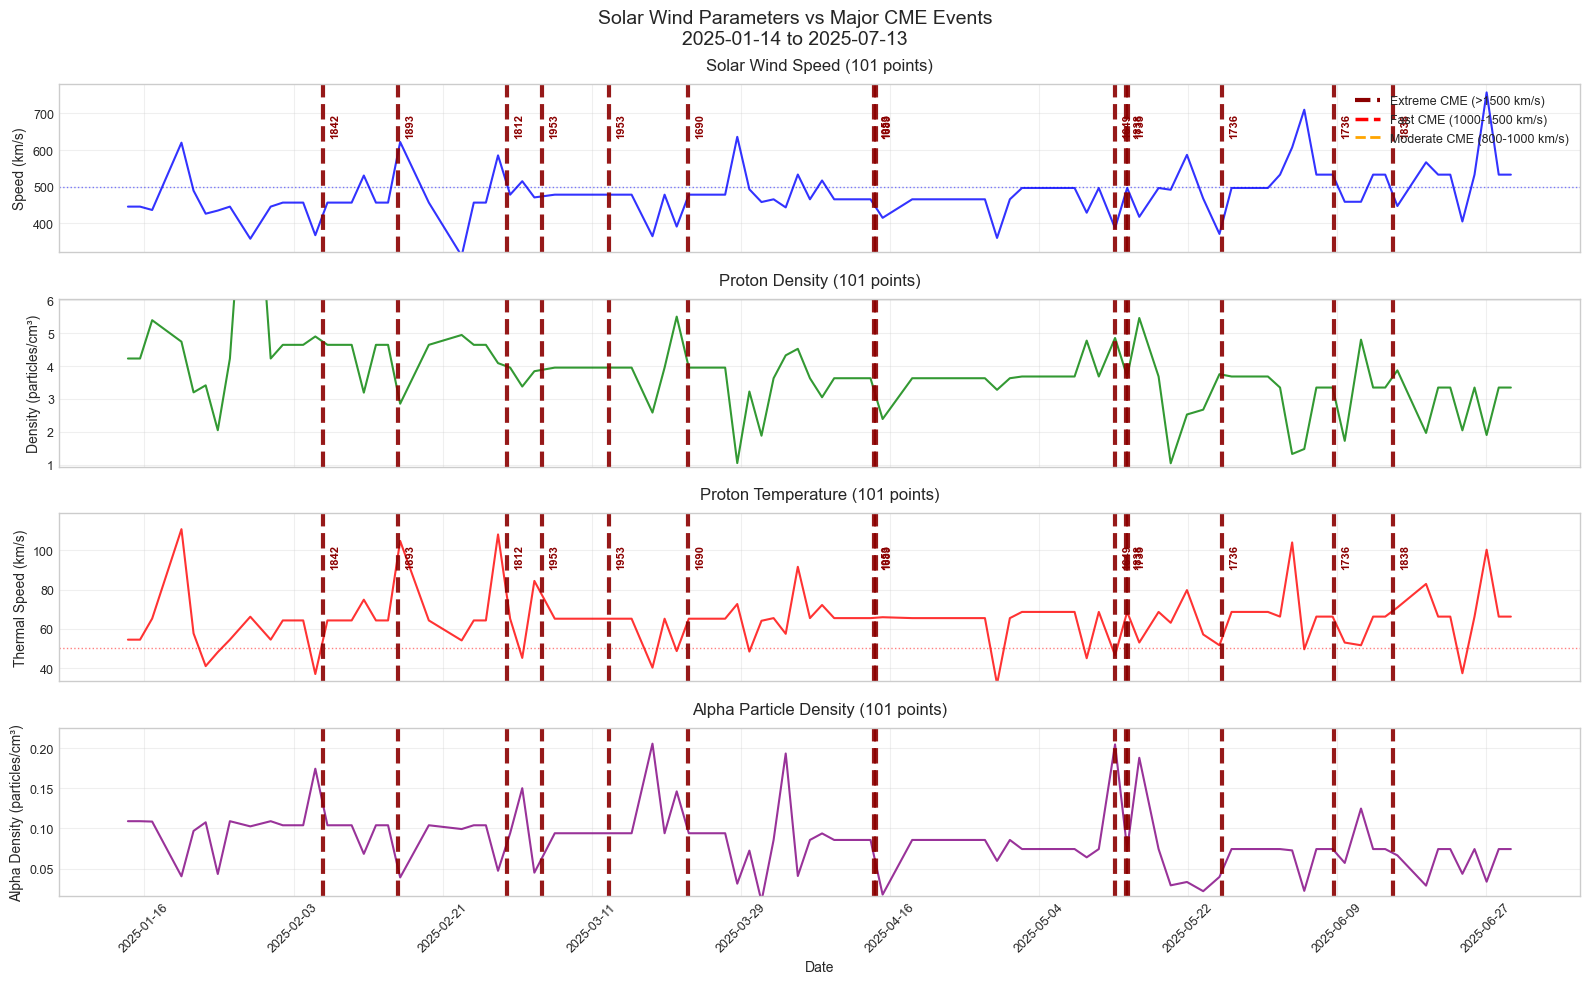


=== Event Summary ===
Showing 14 major CME events (v >= 800 km/s)
Velocity range: 1649 - 1953 km/s
Average velocity: 1808 km/s

Individual events:
  2025-03-04 23:24 - 1953 km/s
  2025-03-13 01:48 - 1953 km/s
  2025-04-14 03:24 - 1953 km/s
  2025-02-15 14:48 - 1893 km/s
  2025-02-06 13:36 - 1842 km/s
  2025-05-14 13:36 - 1838 km/s
  2025-06-15 19:24 - 1838 km/s
  2025-02-28 19:12 - 1812 km/s
  2025-05-26 03:36 - 1736 km/s
  2025-06-08 15:12 - 1736 km/s
  2025-05-14 18:36 - 1735 km/s
  2025-03-22 16:36 - 1690 km/s
  2025-04-14 07:00 - 1689 km/s
  2025-05-13 04:24 - 1649 km/s


In [6]:
print("Creating clean CME analysis plot...")
fig_main, axes_main = create_clean_cme_plot(df_cdf, df_cme, 
                                           time_window_months=6,
                                           min_cme_velocity=800,
                                           data_downsample_factor=100,
                                           max_cme_events=15)

Creating monthly overview...


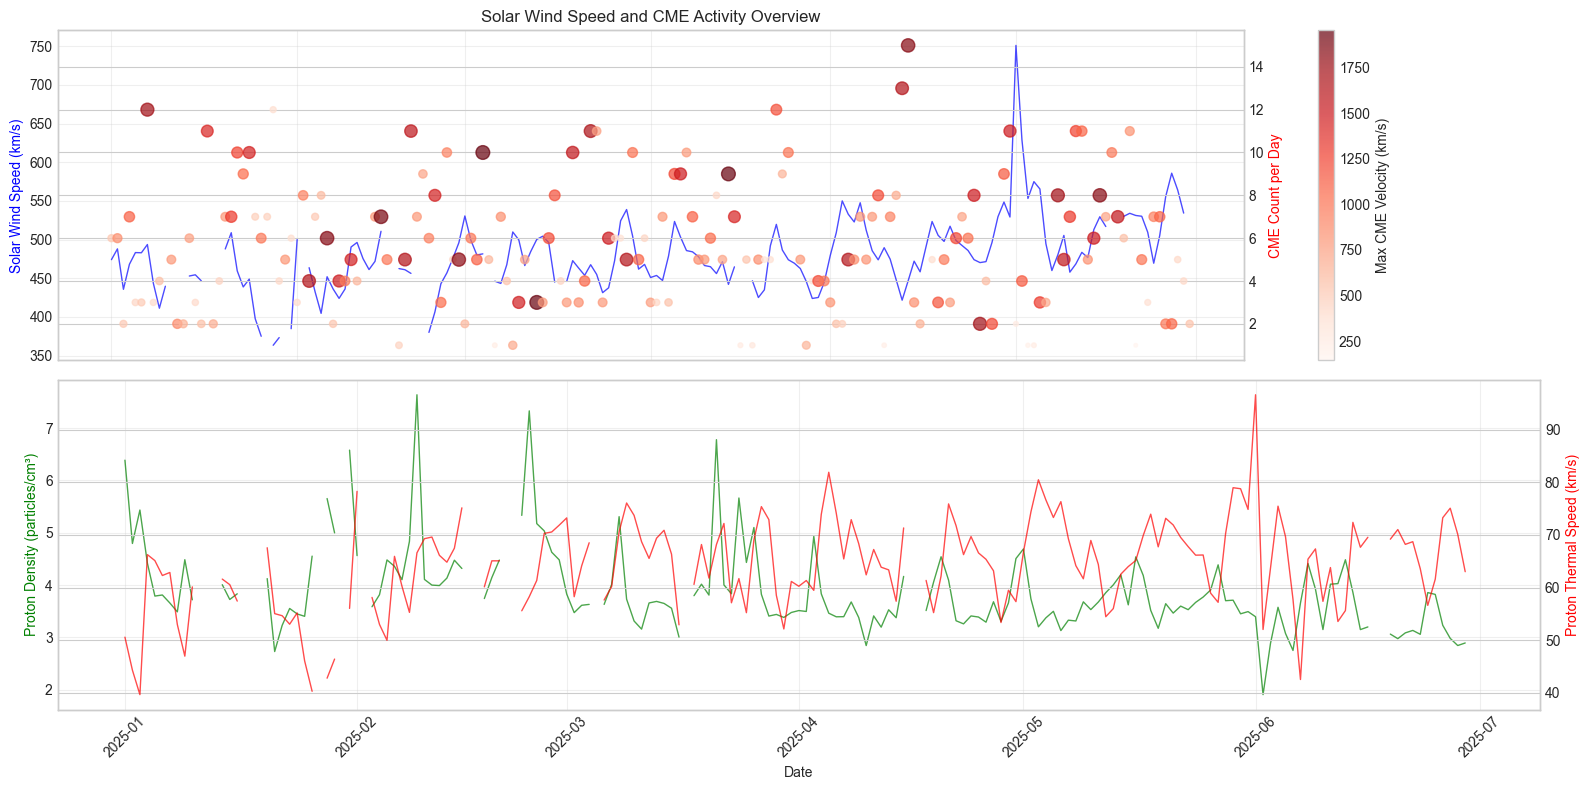

In [7]:
print("Creating monthly overview...")
fig_overview, axes_overview = create_monthly_overview(df_cdf, df_cme)

Creating CME impact analysis...


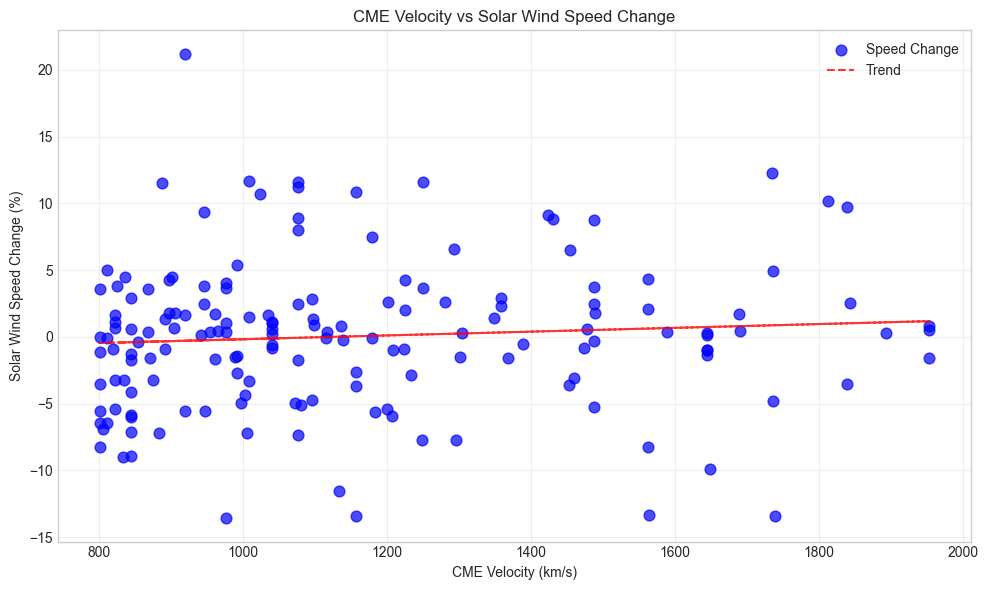


=== Impact Analysis Summary ===
Analyzed 163 CME events
Average speed change: 0.0%
Average density change: 1.0%
Average thermal change: -0.6%


In [8]:
print("Creating CME impact analysis...")
fig_impact, ax_impact, impact_df = create_cme_impact_analysis(df_cdf, df_cme, 
                                                            impact_window_hours=12,
                                                            min_velocity=800)